In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import json
from shapely.geometry import Point, mapping, shape
import openeo
import xarray as xr
from pathlib import Path
import folium
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize, to_hex
from rasterstats import zonal_stats
import branca.colormap as bcm
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge

In [1]:
import wget

url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
wget.download(url)

'countries.geojson'

In [1]:
world = gpd.read_file("countries.geojson", engine="pyogrio")
netherlands = world[world['name'] == "Greece"]
netherlands.to_file("Greece_polygon.geojson", driver="GeoJSON")

In [2]:
athens_center = Point(23.7275, 37.9838)

athens_poly = athens_center.buffer(5)  

athens_geojson = mapping(athens_poly)
with open("Athens_polygon.geojson", "w") as f:
    json.dump(athens_geojson, f, indent=2)

In [4]:
connection = openeo.connect(
    "openeo.dataspace.copernicus.eu"
).authenticate_oidc()

Authenticated using refresh token.


In [5]:
def read_json(filename: str) -> dict:
    with open(filename) as input:
        field = json.load(input)
    return field


date = ["2024-06-01", "2024-06-30"]
aoi = read_json("Greece_polygon.geojson")

In [6]:
m = folium.Map([52.2, 5], zoom_start=7)
folium.GeoJson(aoi).add_to(m)

In [7]:
feat = json.load(open("Greece_polygon.geojson"))["features"][0]

In [8]:
poly = shape(feat["geometry"])


minx, miny, maxx, maxy = poly.bounds


aoi_bbox = {
    "west":  minx,
    "south": miny,
    "east":  maxx,
    "north": maxy
}


In [9]:
ds = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=date,
    spatial_extent=aoi,
    bands=["CO", "dataMask"],
)

co = ds.filter_bands(["CO"])
mask = ds.filter_bands(["dataMask"]) != 0
clean_co = co

co_mean = clean_co

In [10]:
ds = xr.open_dataset(r"C:\Users\maria\Downloads\all_days_co.nc")               # NetCDF engine handles time
print(ds)                                            # should show dims: time, y, x
co_xr = ds["CO"]                                     # or whatever your var name is
print(co_xr.shape)                                   # e.g. (11, 200, 158) for 11 days


<xarray.Dataset>
Dimensions:  (t: 10, x: 158, y: 200)
Coordinates:
  * t        (t) datetime64[ns] 2024-06-20 2024-06-21 ... 2024-06-28 2024-06-29
  * x        (x) float64 19.65 19.71 19.76 19.82 ... 28.06 28.11 28.17 28.22
  * y        (y) float64 41.73 41.7 41.66 41.63 ... 34.93 34.89 34.86 34.82
Data variables:
    crs      |S1 ...
    CO       (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform
(10, 200, 158)


In [11]:
# Force-load the entire dataset so subsequent .isel/.sel work in RAM
ds = xr.open_dataset("all_days_co.nc", engine="netcdf4").load()

co_xr = ds["CO"]                # now a fully in-memory array
co_day = co_xr.isel(t=5)        # no more HDF errors


In [12]:
print(co_day.coords)

Coordinates:
    t        datetime64[ns] 2024-06-25
  * x        (x) float64 19.65 19.71 19.76 19.82 ... 28.06 28.11 28.17 28.22
  * y        (y) float64 41.73 41.7 41.66 41.63 ... 34.93 34.89 34.86 34.82


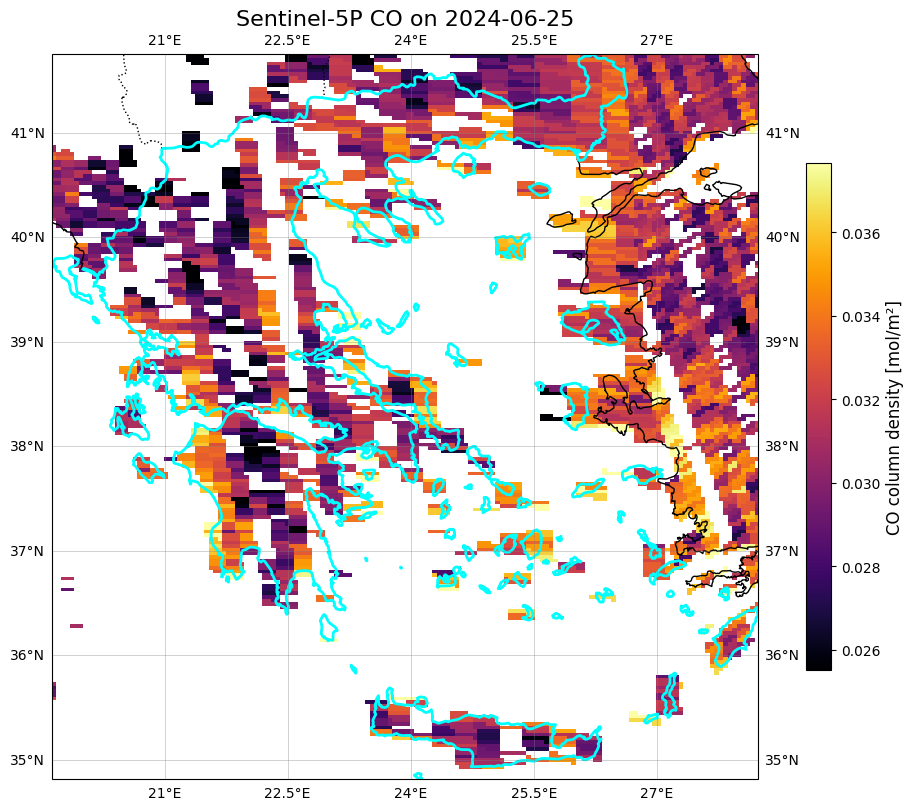

In [13]:
ds = xr.open_dataset("all_days_co.nc", engine="netcdf4").load()
co_day = ds["CO"].isel(t=5)


athens = gpd.read_file("Greece_polygon.geojson", engine="pyogrio")


fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})


im = co_day.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="inferno",
    add_colorbar=False,
    robust=True,
)


cbar = fig.colorbar(im, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("CO column density [mol/m²]", fontsize=12)

athens.boundary.plot(ax=ax, edgecolor='cyan', linewidth=2)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)


minx, miny, maxx, maxy = athens.total_bounds
ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())


ax.set_title(f"Sentinel-5P CO on {str(co_day.t.values)[:10]}", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)


plt.tight_layout()
fig.savefig("co_map_static_pretty.png", dpi=300)
plt.show()


In [14]:
ds = xr.open_dataset("all_days_co.nc", engine="netcdf4").load()
co_day = ds["CO"].isel(t=5)


athens = gpd.read_file("Greece_polygon.geojson", engine="pyogrio")
athens = athens.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)


lons = co_day.coords["x"].values
lats = co_day.coords["y"].values
co_vals = co_day.values


lon2d, lat2d = np.meshgrid(lons, lats)
lon_flat = lon2d.ravel()
lat_flat = lat2d.ravel()
co_flat = co_vals.ravel()


mask = ~np.isnan(co_flat)
lon_flat = lon_flat[mask]
lat_flat = lat_flat[mask]
co_flat = co_flat[mask]

norm = Normalize(vmin=np.percentile(co_flat, 2), vmax=np.percentile(co_flat, 98))
cmap = cm.get_cmap("inferno")  



m = folium.Map(location=[lat_flat.mean(), lon_flat.mean()], zoom_start=7, tiles="cartodbpositron")

for lon, lat, val in zip(lon_flat, lat_flat, co_flat):
    color = to_hex(cmap(norm(val)))
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.9,
        weight=0,
        tooltip=f"CO: {val:.2e} mol/m²"
    ).add_to(m)


folium.GeoJson(
    athens,
    name="Greece AOI",
    style_function=lambda feature: {
        'color': 'cyan',
        'weight': 2,
        'fillOpacity': 0.1,
        'fillColor': 'black'
    }
).add_to(m)


for lon, lat, val in zip(lon_flat[::50], lat_flat[::50], co_flat[::50]):
    color = to_hex(cmap(norm(val)))
    folium.CircleMarker(
        location=[lat, lon],
        radius=4,
        color=color,
        fill=True,
        fill_opacity=0.9,
        weight=0,
        tooltip=f"CO: {val:.2e} mol/m²"
    ).add_to(m)



import branca.colormap as bcm
colormap = bcm.LinearColormap(
    colors=[to_hex(cmap(norm(v))) for v in np.linspace(norm.vmin, norm.vmax, 256)],
    vmin=norm.vmin,
    vmax=norm.vmax,
    caption="CO column density [mol/m²]"
)
colormap.add_to(m)


m.save("co_map_interactive_full.html")
print("Saved: 'co_map_interactive_full.html'. Open it in your browser!")


C:\Users\maria\AppData\Local\Temp\ipykernel_16820\2507626670.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("inferno")


Saved: 'co_map_interactive_full.html'. Open it in your browser!


In [17]:
ds = xr.open_dataset("all_days_co.nc", engine="netcdf4").load()
co_day = ds["CO"].isel(t=5)


regions = gpd.read_file("Greece_regions.geojson", engine="pyogrio").to_crs(epsg=4326)


lons = co_day.coords["x"].values
lats = co_day.coords["y"].values
co_vals = co_day.values


if lats[0] < lats[-1]:
    lats = lats[::-1]
    co_vals = co_vals[::-1, :]


from affine import Affine
res_x = (lons[-1] - lons[0]) / (len(lons) - 1)
res_y = (lats[-1] - lats[0]) / (len(lats) - 1)
transform = Affine.translation(lons[0] - res_x / 2, lats[0] - res_y / 2) * Affine.scale(res_x, res_y)


stats = zonal_stats(
    vectors=regions,
    raster=co_vals,
    affine=transform,
    stats=["mean"],
    nodata=np.nan,
    geojson_out=True
)


region_means = gpd.GeoDataFrame.from_features(stats)
region_means.set_crs(regions.crs, inplace=True)
region_means = region_means.to_crs(epsg=4326)



values = region_means["mean"].values
norm = Normalize(vmin=np.nanpercentile(values, 2), vmax=np.nanpercentile(values, 98))
cmap = cm.get_cmap("inferno")
region_means["color"] = [to_hex(cmap(norm(v))) if not np.isnan(v) else "#cccccc" for v in values]


m = folium.Map(location=[lats.mean(), lons.mean()], zoom_start=7, tiles="cartodbpositron")


folium.GeoJson(
    region_means,
    style_function=lambda feature: {
        'fillColor': feature["properties"]["color"],
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(fields=["mean"], aliases=["CO mean [mol/m²]"])
).add_to(m)


colormap = bcm.LinearColormap(
    colors=[to_hex(cmap(norm(v))) for v in np.linspace(norm.vmin, norm.vmax, 256)],
    vmin=norm.vmin,
    vmax=norm.vmax,
    caption="Average CO per Region [mol/m²]"
)
colormap.add_to(m)


m.save("co_choropleth_interactive.html")
print("✅ Saved: co_choropleth_interactive.html — open it in your browser.")


C:\Users\maria\AppData\Local\Temp\ipykernel_16820\30241357.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("inferno")


✅ Saved: co_choropleth_interactive.html — open it in your browser.


In [ ]:
ds    = xr.open_dataset("all_days_co.nc")
co_xr = ds["CO"]                # dims (t, y, x)
times = co_xr["t"].values.astype("datetime64[s]").astype(float)
lats  = co_xr["y"].values
lons  = co_xr["x"].values
T, Y, X = np.meshgrid(times, lats, lons, indexing="ij")
features = np.stack([T.ravel(), Y.ravel(), X.ravel()], axis=1)
values   = co_xr.values.ravel()


mask_train = ~np.isnan(values)
X_train, y_train = features[mask_train], values[mask_train]
X_pred           = features[~mask_train]

# 3) Build RFF map (approx RBF kernel)
#    gamma = 1/(2*l^2); here l_spatial≈0.2deg, l_time≈2days→scale columns accordingly
#    To keep it simple, normalize all dims to similar variance:
scales = np.array([86400*2, 0.2, 0.2])  # temporal in seconds, spatial in deg
X_scaled = features / scales
rff = RBFSampler(gamma=1.0, n_components=1000, random_state=0)
Z = rff.fit_transform(X_scaled[mask_train])

# 4) Fit a fast linear model
ridge = Ridge(alpha=1.0)
ridge.fit(Z, y_train)

# 5) Transform and predict missing
Z_pred = rff.transform(X_scaled[~mask_train])
y_pred = ridge.predict(Z_pred)

# 6) Reassemble into filled cube
filled = values.copy()
filled[~mask_train] = y_pred
filled_cube = filled.reshape(co_xr.shape)
co_filled   = xr.DataArray(filled_cube, dims=co_xr.dims, coords=co_xr.coords, name="CO_filled")


In [ ]:
day_idx = 3
co_day  = co_filled.isel(t=day_idx)


arr  = co_day.values            # shape (y, x)
lons = co_filled["x"].values
lats = co_filled["y"].values
extent = [lons.min(), lons.max(), lats.min(), lats.max()]


athens = gpd.read_file("Athens_polygon.geojson",engine = 'pyogrio')
minx, miny, maxx, maxy = athens.total_bounds


fig, ax = plt.subplots(
    figsize=(8,8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
im = ax.imshow(
    arr,
    origin="upper",
    extent=extent,
    transform=ccrs.PlateCarree(),
    cmap="inferno"
)
cbar = fig.colorbar(im, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label("Filled CO [mol/m²]")

athens = gpd.read_file("Greece_polygon.geojson", engine="pyogrio")
minx, miny, maxx, maxy = athens.total_bounds
# overlay features and zoom
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

ax.set_title(f"Gaussian-filled CO on {str(co_day['t'].values)[:10]}")
plt.tight_layout()
plt.show()


